<a href="https://colab.research.google.com/github/aahFancyGun/dataScienceClass/blob/master/unit2/YangChauU2Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction#

The following model was designed to represent the chance that in a given year thirty percent of the the American population or more will be considered normal weight. Many assumptions made during this project were informed by America's status as one of the most obese countries in the world.

1. Threshold of 30% wherein I am questioning whether or not the percentage of overweight people is above or below this number

2. Data is condensed by the source into a few key averages that summarize all demographics / age ranges

My project seeks to analyze the "continuity of obesity" in America and model graph that represents the most likely outcomes of years to come.

##But why is that important?##

With the obesity epidemic being such a severe health issue in many well developed countries like America, there is an ever growing need to analyze and understand how and why the obesity epidemic is even happening. One way of understanding it is through a statistics, which would allow governmental health authorities to better visualize and predict how American health will change in the coming years.

In [ ]:
!pip install "preliz[full,notebook]"


In [2]:
import pandas as pd
import numpy as np
import preliz as pz
import arviz as az
import pymc as pm


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [28]:
url = 'https://raw.githubusercontent.com/aahFancyGun/dataScienceClass/master/unit2/obesityData.csv'

obesity = pd.read_csv(url)
#reading from downloaded obesityData.csv

obesity

,INDICATOR,PANEL,PANEL_NUM,UNIT,UNIT_NUM,STUB_NAME,STUB_NAME_NUM,STUB_LABEL,STUB_LABEL_NUM,YEAR,YEAR_NUM,AGE,AGE_NUM,ESTIMATE,SE,FLAG
0,"Normal weight, overweight, and obesity among a...",Normal weight (BMI from 18.5 to 24.9),1,"Percent of population, age-adjusted",1,Total,1,20 years and over,1.10,1988-1994,1,20 years and over,1.0,41.6,0.8,NaN
1,"Normal weight, overweight, and obesity among a...",Normal weight (BMI from 18.5 to 24.9),1,"Percent of population, age-adjusted",1,Total,1,20 years and over,1.10,1999-2002,2,20 years and over,1.0,33.0,0.8,NaN
2,"Normal weight, overweight, and obesity among a...",Normal weight (BMI from 18.5 to 24.9),1,"Percent of population, age-adjusted",1,Total,1,20 years and over,1.10,2001-2004,3,20 years and over,1.0,32.3,0.7,NaN
3,"Normal weight, overweight, and obesity among a...",Normal weight (BMI from 18.5 to 24.9),1,"Percent of population, age-adjusted",1,Total,1,20 years and over,1.10,2003-2006,4,20 years and over,1.0,31.6,0.8,NaN
4,"Normal weight, overweight, and obesity among a...",Normal weight (BMI from 18.5 to 24.9),1,"Percent of population, age-adjusted",1,Total,1,20 years and over,1.10,2005-2008,5,20 years and over,1.0,30.8,0.7,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3355,"Normal weight, overweight, and obesity among a...",Grade 3 obesity (BMI greater than or equal to ...,6,"Percent of population, crude",2,Sex and age,6,Female: 75 years and over,6.26,2007-2010,6,75 years and over,1.6,3.4,0.8,*
3356,"Normal weight, overweight, and obesity among a...",Grade 3 obesity (BMI greater than or equal to ...,6,"Percent of population, crude",2,Sex and age,6,Female: 75 years and over,6.26,2009-2012,7,75 years and over,1.6,4.1,1.1,*
3357,"Normal weight, overweight, and obesity among a...",Grade 3 obesity (BMI greater than or equal to ...,6,"Percent of population, crude",2,Sex and age,6,Female: 75 years and over,6.26,2011-2014,8,75 years and over,1.6,3.3,1.0,*
3358,"Normal weight, overweight, and obesity among a...",Grade 3 obesity (BMI greater than or equal to ...,6,"Percent of population, crude",2,Sex and age,6,Female: 75 years and over,6.26,2013-2016,9,75 years and over,1.6,3.4,0.7,NaN


#Prior#
Based off the knowledge that America is one of the most obese countries in the world I am assuming that over the years 1988 to 2014 forty percent of the time thirty percent or more of the population will be considered normal weight while sixty percent of the time less than 30 percent will be considered normal weight.

1. America is currently tenth in the world for most obese country

2. Lack of regulatory laws to prevent the American populace from consuming overly unhealthy foods

3. Inflation, economic turmoil means many Americans have been forced to turn to less healthy alternatives to not starve

<Axes: >

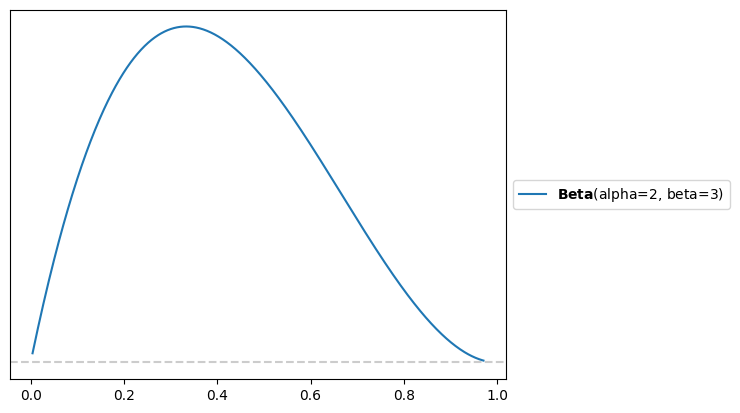

In [4]:
pz.Beta(alpha = 2, beta = 3).plot_pdf()
#graph of prior


In [5]:
normalWeightDataQuery = obesity.query('PANEL == "Normal weight (BMI from 18.5 to 24.9)" and STUB_LABEL == "20 years and over" and UNIT == "Percent of population, age-adjusted"')
#querying data
normalWeight = normalWeightDataQuery[["ESTIMATE"]]
#taking the data from the "estimate" column of queried data
normalWeight
#printing it out for debugging purposes

,ESTIMATE
0,41.6
1,33.0
2,32.3
3,31.6
4,30.8
5,29.8
6,29.6
7,28.9
8,27.7
9,26.0


In [25]:
normWeights = np.repeat(1,5)
#how many years with 30% or more people who aren't overweight
obeseWeights = np.repeat(0,5)
#how many years with less than 30% of people who aren't overweight

weights = np.concatenate( [normWeights,obeseWeights] )

with pm.Model() as wmby_FT_model:

  θ = pm.Beta('θ' , alpha = 2. , beta = 3.)
  #defining prior
  y = pm.Bernoulli('y', p = θ, observed = weights)
  #defining likelihood in consort with prior
  idata_Obesity = pm.sample(1000)
  #generating data

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


<Axes: title={'center': 'θ'}>

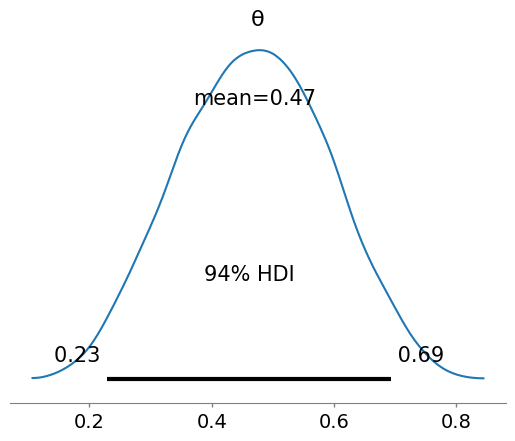

In [26]:
az.plot_posterior(idata_Obesity)
#plotting posterior

#PYMC graph analysis#


In my prior I predicted that 40 percent of the time 30 percent or more people would be consisdered normal weight and the posterior ended up being just seven percent above that estimation, which while it isn't super substantial is definitely some good news for America. That said, I did not expect to be able to predict the results with such accurazy. Although I believed it would be quite severe with the majority of the population suffering from some form of obesity I did feel that my prior was overshooting to a degree and it appears that this feeling was correct. I don't claim to be an expert or even remotely knowledgeable in this field of study but I'd like to think that if someone like me with such limited knowledge on the subject can predict with this degree of accuracy maybe public awareness of the obesity epidemic is on the rise. That is not to say that 47% of the time only 30% or more of people will be of healthy weight is a good statistic. That would still indicate that the majority of the time, less than 30% of the people can even be considered healthy.